In [ ]:
!pip install vbeam

# Simplified RTB Apodization/Spatial Weighting
This notebook attempts to explain the details behind the `vbeam.apodization.rtb.rtb_apodization` and subsequently the `RTBApodization` class. It uses the `vbeam.util.geometry.v2` module for constructing the geometry of the problem and so it can be a bit hard to read at first. This notebook takes you through (most of) the code and explains why it is how it is.

Note that RTB apodization in vbeam is quite simple and doesn't reflect how a real focused wave behaves in the medium.


First, let's start by defining where our (2D) array starts and ends and the position of the virtual source used for focusing.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from vbeam.scan import linear_scan
from vbeam.util.geometry.v2 import Line

scan = linear_scan(np.linspace(-2, 2, 100), np.linspace(-0.5, 3.5, 100))

array_left = np.array([-1, 0])
array_right = np.array([1, 0])
source = np.array([0.8, 1])

Let's then plot what the final result of the RTB apodization should look like.

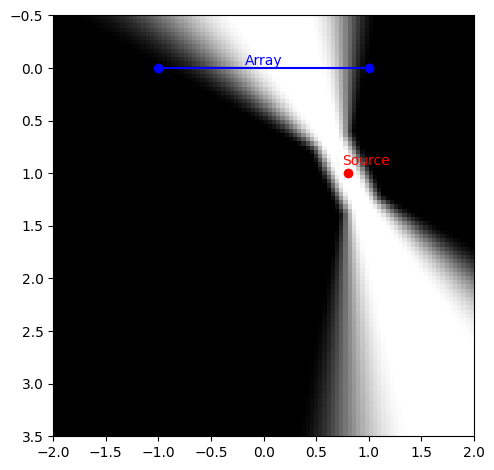

In [2]:
from spekk import Spec

from vbeam.apodization import (
    RTBApodization,
    Tukey75,
    get_apodization_values,
)
from vbeam.core import ElementGeometry, WaveData


# Let's put plotting array and source into a function because we'll use it a lot
def plot_array_and_source(ax, array_left, array_right, source):
    xs = np.array([array_left[0], array_right[0]])
    zs = np.array([array_left[1], array_right[1]])
    ax.plot(xs, zs, color="blue")
    ax.scatter(xs, zs, color="blue")
    ax.text(np.mean(xs), np.max(zs), "Array", ha="center", va="bottom", color="blue")
    ax.scatter(*source, color="red")
    ax.text(*source - 0.05, "Source", ha="left", va="bottom", color="red")


apodization = RTBApodization(2, 0.5, Tukey75())
sender = receiver = ElementGeometry(np.array([0, 0, 0]))
wave_data = WaveData(np.array([source[0], 0, source[1]]))
spec = Spec({"point_position": ["xs", "zs"]})
apodization_values = get_apodization_values(
    apodization,
    sender,
    scan.get_points(flatten=False),
    receiver,
    wave_data,
    spec,
    ["xs", "zs"],
)

plt.imshow(apodization_values.T, extent=scan.bounds, origin="lower", cmap="gray")
plot_array_and_source(plt, array_left, array_right, source)
plt.xlim([-2, 2])
plt.ylim([-0.5, 3.5])
plt.gca().invert_yaxis()
plt.gca().set_aspect("equal")
plt.tight_layout()

Note, again, that this apodization function is a simplification of how the wave truly behaves in the medium.

# How RTB Apodization Is Implemented In vbeam
We start by drawing a line from each side of the array that passes through the source point. The `Line` object has a method called `signed_distance` (SDF) which can be used to calculate the (signed) distance from a point to the nearest point on the line, where the sign indicate whether the point is on the "left side" or the "right side" of the line.

Let's calculate the signed distance to every point in the scan for each of the lines.

In [3]:
line_left = Line.passing_through(array_left, source)
line_right = Line.passing_through(array_right, source)

points = scan.get_points(flatten=False)
points = points[..., [0, 2]]  # Scans are 3D, but we only need x and z
line_left_sd = line_left.signed_distance(points)
line_right_sd = line_right.signed_distance(points)

Let's plot the absolute of these (signed) distances below. Notice that the distance is 0 on the line that goes from the array and through the source.

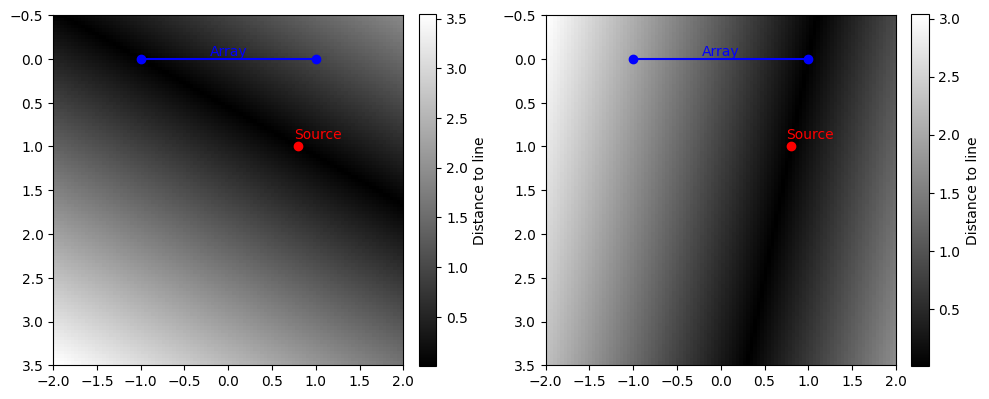

In [4]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
im1 = ax[0].imshow(np.abs(line_left_sd).T, extent=scan.bounds, origin="lower", cmap="gray")
im2 = ax[1].imshow(np.abs(line_right_sd).T, extent=scan.bounds, origin="lower", cmap="gray")
plot_array_and_source(ax[0], array_left, array_right, source)
plot_array_and_source(ax[1], array_left, array_right, source)
ax[0].invert_yaxis()
ax[1].invert_yaxis()
fig.colorbar(im1, ax=ax[0], label="Distance to line", fraction=0.046, pad=0.04)
fig.colorbar(im2, ax=ax[1], label="Distance to line", fraction=0.046, pad=0.04)
fig.tight_layout()


If we don't take the absolute value, it looks like the result from the cell below.

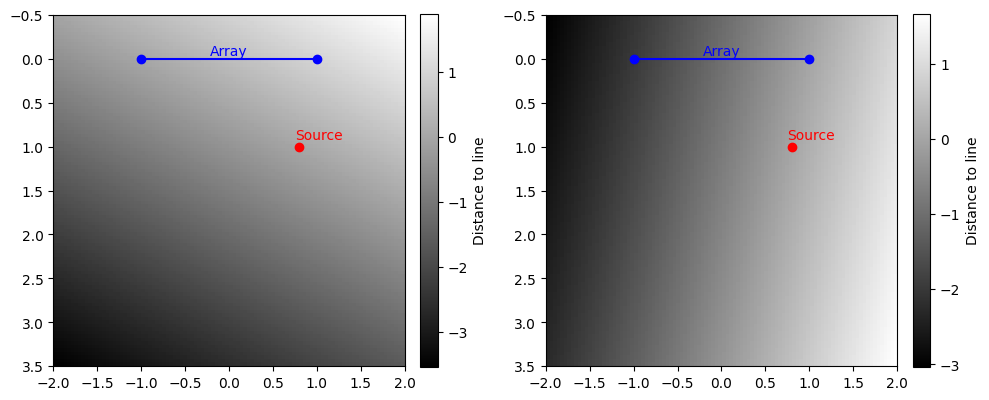

In [5]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
im1 = ax[0].imshow(line_left_sd.T, extent=scan.bounds, origin="lower", cmap="gray")
im2 = ax[1].imshow(line_right_sd.T, extent=scan.bounds, origin="lower", cmap="gray")
plot_array_and_source(ax[0], array_left, array_right, source)
plot_array_and_source(ax[1], array_left, array_right, source)
ax[0].invert_yaxis()
ax[1].invert_yaxis()
fig.colorbar(im1, ax=ax[0], label="Distance to line", fraction=0.046, pad=0.04)
fig.colorbar(im2, ax=ax[1], label="Distance to line", fraction=0.046, pad=0.04)
fig.tight_layout()

Notice that the signed distance of the lines are negative for the points on the left side of the lines and positive on the right side. We can use this to our advantage.

Our goal is to create an hourglass shape defined as the area between the lines. The upper half of this hourglass correspond to all the points where the signed distance to the left line is positive and the signed distance to the right line is negative. Likewise, the lower half of the hourglass correpond to all the points where the signed distance to the left line is negative and the signed distance to the right line is positive.

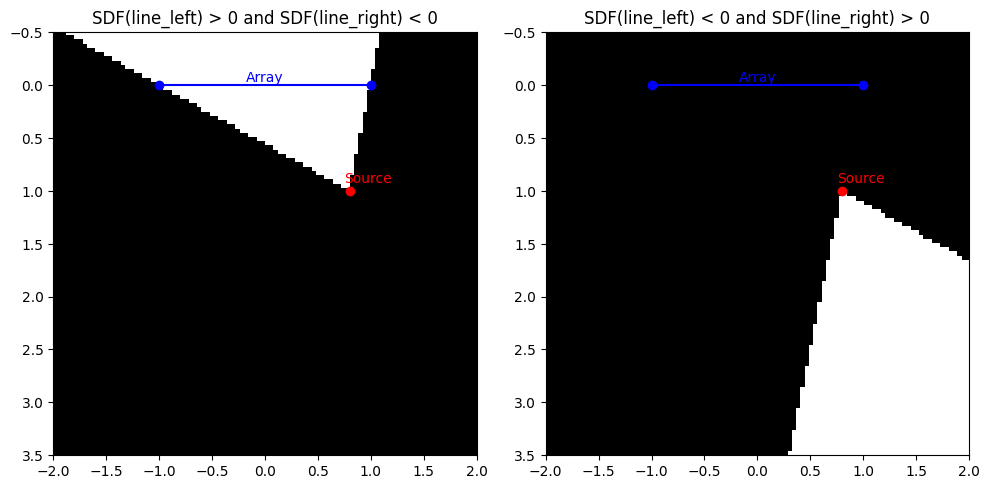

In [6]:
line_left_positive = line_left_sd >= 0
line_right_negative = line_right_sd <= 0
# The upper part of the hourglass is where the left line is positive and the right line
# is negative.
hourglass_upper_half = line_left_positive & line_right_negative

line_left_negative = line_left_sd <= 0
line_right_positive = line_right_sd >= 0
# The lower part of the hourglass is where the left line is negative and the right line
# is positive.
hourglass_lower_half = line_left_negative & line_right_positive

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
im1 = ax[0].imshow(hourglass_upper_half.T, extent=scan.bounds, origin="lower", cmap="gray")
im2 = ax[1].imshow(hourglass_lower_half.T, extent=scan.bounds, origin="lower", cmap="gray")
plot_array_and_source(ax[0], array_left, array_right, source)
plot_array_and_source(ax[1], array_left, array_right, source)
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].set_title("SDF(line_left) > 0 and SDF(line_right) < 0")
ax[1].set_title("SDF(line_left) < 0 and SDF(line_right) > 0")
fig.tight_layout()


This can be simplified as all the points where the sign of the SDF of the left line and the sign of the SDF of the right line are opposite. If we multiply the SDF of each together, then the result should be negative where the signs are opposite and positive where they have the same sign. Therefore, the hourglass can be defined as all the points where the product of the SDFs are negative.

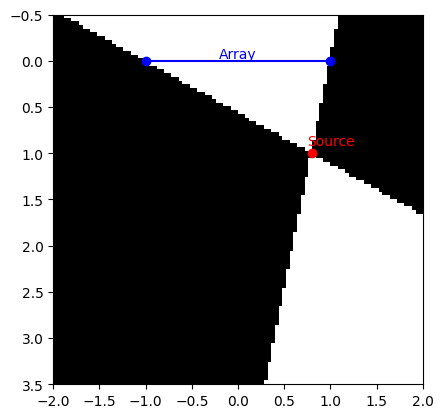

In [7]:
full_hourglass = (line_left_sd * line_right_sd) <= 0

plt.imshow(full_hourglass.T, extent=scan.bounds, origin="lower", cmap="gray")
plot_array_and_source(plt, array_left, array_right, source)
plt.gca().invert_yaxis()


Now we've got an hourglass apodization! Hurra!

However, notice how it is very narrow around the source. This means that no pixels will be included in this area. We can fix this by defining another line that passes through the source, with a given thickness, and take the union of it and the hourglass.

First, let's define the line. Then we calculate the distance to the line and mask all the points where the distance is less than or equal to a minimum width.

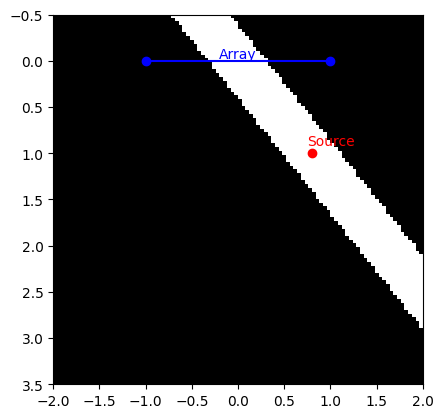

In [8]:
# How wide the apodization should be around the source
minimum_width = 0.5

# We define the line as coming from the center of the array.
# This is not correct (!), but bare with me for now.
array_center = (array_left + array_right) / 2
mid_line = Line.passing_through(array_center, source)
mid_line_mask = np.abs(mid_line.signed_distance(points)) <= minimum_width/2

plt.imshow(mid_line_mask.T, extent=scan.bounds, origin="lower", cmap="gray")
plot_array_and_source(plt, array_left, array_right, source)
plt.gca().invert_yaxis()


Let's combine the hourglass with the mid line.

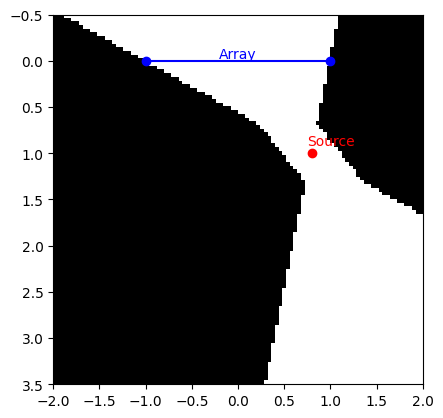

In [9]:
hourglass_with_mid_line = full_hourglass | mid_line_mask

plt.imshow(hourglass_with_mid_line.T, extent=scan.bounds, origin="lower", cmap="gray")
plot_array_and_source(plt, array_left, array_right, source)
plt.gca().invert_yaxis()


In [10]:
def get_apodization(points, array_left, array_right, source, minimum_width):
    line_left = Line.passing_through(array_left, source)
    line_right = Line.passing_through(array_right, source)
    mid_line = Line.passing_through(array_center, source)

    line_left_sd = line_left.signed_distance(points)
    line_right_sd = line_right.signed_distance(points)
    hourglass = (line_left_sd * line_right_sd) <= 0
    mid_line_mask = np.abs(mid_line.signed_distance(points)) <= minimum_width/2

    return hourglass | mid_line_mask


def plot_apodization(source_x, source_z, array_width, minimum_width):
    array_left = np.array([-array_width / 2, 0])
    array_right = np.array([array_width / 2, 0])
    source = np.array([source_x, source_z])
    apodization = get_apodization(
        points, array_left, array_right, source, minimum_width
    )
    plt.imshow(apodization.T, extent=scan.bounds, origin="lower", cmap="gray")
    plot_array_and_source(plt, array_left, array_right, source)
    plt.gca().invert_yaxis()


from ipywidgets import interact

interact(
    plot_apodization,
    source_x=(-1.5, 1.5, 0.01),
    source_z=(0.5, 3, 0.01),
    array_width=(0.5, 3, 0.01),
    minimum_width=(0.1, 1.0, 0.01),
)


interactive(children=(FloatSlider(value=0.0, description='source_x', max=1.5, min=-1.5, step=0.01), FloatSlide…

<function __main__.plot_apodization(source_x, source_z, array_width, minimum_width)>

There is a subtle bug in the implementation of the mid line. The mid line is defined as passing through the center of the array and the source, but this makes it not line up with the hourglass direction. You can see that it looks a bit weird when the source is far to the side of the array; the mid line is angled differently from (and not centered on) the hourglass.

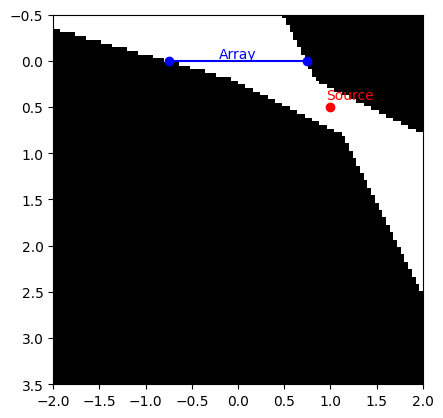

In [11]:
plot_apodization(source_x=1, source_z=0.5, array_width=1.5, minimum_width=0.4)


The problem is that we're passing the mid line through the center of the array and not the center of the arc that represent the transmitted spherical wave. This is best understood if visualized, so run the next cell before continuing to read.

The virtual source model models a spherical wave converging into a point: the source. But since we only have a finite array we can only simulate a part of it, so what we actually get is an arc that converges into the point. We need the mid line to pass through the center of this arc in order to have the same angle as the hourglass.

In [12]:
from matplotlib import patches

@interact(source_x=(-1.5, 1.5, 0.01), source_z=(0.2, 2.4, 0.01), array_width=(0.2, 3, 0.01))
def plot_circle_mid(source_x=0.8, source_z=1, array_width=2):
    # The code in this function is mostly just for plotting, so don't worry about it :)
    source = np.array([source_x, source_z])
    array_left = np.array([-array_width / 2, 0])
    array_right = np.array([array_width / 2, 0])
    plot_array_and_source(plt, array_left, array_right, source)

    dist_from_source = np.linalg.norm(array_center - source)
    angle_array_left = np.arctan2(array_left[1] - source[1], array_left[0] - source[0])
    angle_array_right = np.arctan2(array_right[1] - source[1], array_right[0] - source[0])
    avg_angle = (angle_array_left + angle_array_right) / 2

    plt.plot([array_left[0], source[0]], [array_left[1], source[1]], "--", lw=0.5, color="blue", alpha=0.5)
    plt.plot([array_right[0], source[0]], [array_right[1], source[1]], "--", lw=0.5, color="blue", alpha=0.5)
    plt.plot([source[0], source[0] + dist_from_source * np.cos(avg_angle)], [source[1], source[1] + dist_from_source * np.sin(avg_angle)], lw=1, color="red")
    plt.plot([array_center[0], source[0]], [array_center[1], source[1]], lw=1, linestyle="--", color="blue")

    circle = plt.Circle(source, dist_from_source, color="r", fill=True, lw=0.5, alpha=0.1)
    arc = patches.Arc(source, dist_from_source * 2, dist_from_source * 2, theta1=angle_array_left / np.pi * 180, theta2=angle_array_right / np.pi * 180, color="r", linestyle="-", lw=2)
    plt.gca().add_patch(circle)
    plt.gca().add_patch(arc)
    plt.xlim([-2, 2])
    plt.ylim([-0.5, 2.5])
    plt.gca().invert_yaxis()
    plt.gca().set_aspect("equal")
    plt.tight_layout()


interactive(children=(FloatSlider(value=0.8, description='source_x', max=1.5, min=-1.5, step=0.01), FloatSlide…

Luckily, this is quite easy to do. We know the angle from the source to the left and the right side of the array. The middle point of the arc will be at the average angle of the two. Thus, we construct a line that passes through the source, and with direction vector corresponding to the average angle.

In [13]:
angle_array_left = np.arctan2(array_left[1] - source[1], array_left[0] - source[0])
angle_array_right = np.arctan2(array_right[1] - source[1], array_right[0] - source[0])
avg_angle = (angle_array_left + angle_array_right) / 2

mid_line_direction = np.array([np.cos(avg_angle), np.sin(avg_angle)])
mid_line = Line(source, mid_line_direction)
correct_mid_line_mask = np.abs(mid_line.signed_distance(points)) <= minimum_width/2

Let's plot the previous (incorrect) version of the mid line and the correct version side-by-side:

In [14]:
def get_apodization_correct(points, array_left, array_right, source, minimum_width):
    line_left = Line.passing_through(array_left, source)
    line_right = Line.passing_through(array_right, source)

    angle_array_left = np.arctan2(array_left[1] - source[1], array_left[0] - source[0])
    angle_array_right = np.arctan2(array_right[1] - source[1], array_right[0] - source[0])
    avg_angle = (angle_array_left + angle_array_right) / 2
    mid_line_direction = np.array([np.cos(avg_angle), np.sin(avg_angle)])
    mid_line = Line(source, mid_line_direction)

    line_left_sd = line_left.signed_distance(points)
    line_right_sd = line_right.signed_distance(points)
    hourglass = (line_left_sd * line_right_sd) <= 0
    mid_line_mask = np.abs(mid_line.signed_distance(points)) <= minimum_width/2

    return hourglass | mid_line_mask


def plot_correct_apodization(source_x=1, source_z=0.5, array_width=2, minimum_width=0.5):
    array_left = np.array([-array_width / 2, 0])
    array_right = np.array([array_width / 2, 0])
    source = np.array([source_x, source_z])
    apodization1 = get_apodization(
        points, array_left, array_right, source, minimum_width
    )
    apodization2 = get_apodization_correct(
        points, array_left, array_right, source, minimum_width
    )
    fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
    ax[0].imshow(apodization1.T, extent=scan.bounds, origin="lower", cmap="gray")
    ax[1].imshow(apodization2.T, extent=scan.bounds, origin="lower", cmap="gray")
    plot_array_and_source(ax[0], array_left, array_right, source)
    plot_array_and_source(ax[1], array_left, array_right, source)
    ax[0].invert_yaxis()
    ax[1].invert_yaxis()
    ax[0].set_title("Incorrect mid line")
    ax[1].set_title("Correct mid line")
    fig.tight_layout()

interact(
    plot_correct_apodization,
    source_x=(-1.5, 1.5, 0.01),
    source_z=(0.5, 3, 0.01),
    array_width=(0.5, 3, 0.01),
    minimum_width=(0.1, 1.0, 0.01),
)

interactive(children=(FloatSlider(value=1.0, description='source_x', max=1.5, min=-1.5, step=0.01), FloatSlide…

<function __main__.plot_correct_apodization(source_x=1, source_z=0.5, array_width=2, minimum_width=0.5)>

# Aperture window
There's one more aspect to the RTB apodization function that I have not mentioned: aperture windows. It is visualized in the cell below.

To be continued... :)

In [15]:
from vbeam.apodization import Bartlett, Hamming, Rectangular, Tukey25, Tukey50, Tukey75


def plot_correct_apodization(
    window, source_x=1, source_z=0.5, array_width=2, minimum_width=0.5
):
    array_left = np.array([-array_width / 2, 0])
    array_right = np.array([array_width / 2, 0])
    source = np.array([source_x, source_z])
    apodization = RTBApodization(array_width, minimum_width, window)
    wave_data = WaveData(np.array([source[0], 0, source[1]]))
    apodization_values = get_apodization_values(
        apodization,
        sender,
        scan.get_points(flatten=False),
        receiver,
        wave_data,
        spec,
        ["xs", "zs"],
    )
    plt.imshow(apodization_values.T, extent=scan.bounds, origin="lower", cmap="gray")
    plot_array_and_source(plt, array_left, array_right, source)
    plt.gca().invert_yaxis()
    fig.tight_layout()


interact(
    plot_correct_apodization,
    window=[
        ["Rectangular", Rectangular()],
        ["Hamming", Hamming()],
        ["Tukey25", Tukey25()],
        ["Tukey50", Tukey50()],
        ["Tukey75", Tukey75()],
        ["Bartlett", Bartlett()],
    ],
    source_x=(-1.5, 1.5, 0.01),
    source_z=(0.5, 3, 0.01),
    array_width=(0.5, 3, 0.01),
    minimum_width=(0.1, 1.0, 0.01),
)

interactive(children=(Dropdown(description='window', options=(['Rectangular', Rectangular()], ['Hamming', Hamm…

<function __main__.plot_correct_apodization(window, source_x=1, source_z=0.5, array_width=2, minimum_width=0.5)>